<a href="https://colab.research.google.com/github/armandordorica/MIE1516_A2_Gibbs_sampling/blob/master/A2_Gibbs_sampling_query_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math  
import numpy as np
import pandas as pd
import collections
from scipy.stats import sem, t
from scipy import mean
import matplotlib.pyplot as plt
# import json

### Global Functions

In [0]:
def plot_95_pct_confidence_interval(data_df, var, step): 
  """
  Input: dataframe, variable on dataframe to plot, burning step 
  """
  lower_bounds = []
  upper_bounds = []
  means= []
  # data_df = data_df[step:]
  # query3 = [0.333] * len(data_df)
  query2 = [0.4667]* len(data_df)
  for i in range(1, len(data_df[var])):
    sample_mean = data_df[var][0:i].mean()
    std_error = math.sqrt(data_df[var][0:i].var()/len(data_df))
    Z = 1.96 # based on 95% confidence interval
    epsilon = Z * std_error
    lower_bounds.append(sample_mean - epsilon)
    upper_bounds.append(sample_mean + epsilon)
    means.append(sample_mean)
  
  
  print({ 'Pr[0]': 1- data_df[var].mean(), 'Pr[1]':data_df[var].mean()})
  plt.plot(lower_bounds[step:], label = 'Lower bound')
  plt.plot(upper_bounds[step:], label= 'Upper bound')
  plt.plot(means[step:], label = 'Running average')
  plt.plot(query2, label = 'True value')
  # plt.legend()
  plt.xlabel("Number of sampling rounds")
  plt.ylabel("Prob of query having a value 1")
  #return means


def mean_confidence_interval(data): 
  confidence = 0.95

  n = len(data)
  mean = np.mean(data)
  std_err = sem(data)
  h = std_err * t.ppf((1 + confidence) / 2, n - 1)

  start = mean - h
  end = mean + h

  return start, mean, end
# Sample variable from list of dataframes 
def list_of_dicts_to_df(list_of_dicts):
  df = None
  df = dictionary_to_df(list_of_dicts[0])
  for i in range(1, len(list_of_dicts)):
    df2 = dictionary_to_df(list_of_dicts[i])
    df = pd.concat([df, df2], ignore_index=True, sort=False)
  return df

def sample_var_from_list_of_dfs(my_list_of_dfs, var_to_sample):
  """
  Input: Expects a list of dataframes that will contain var_to_sample 
  Output: Returns a viable value for the sampling of this variable 
  """
  list_of_assoc_dfs = dfs_that_contain_var(my_list_of_dfs, var_to_sample)
  value = sample_value_from_simple_df(list_of_assoc_dfs[0][[var_to_sample, 'Pr']])
  return value

def dfs_that_contain_var(list_of_dfs, var_to_sample):
  ### Given a list of dfs, return a list of the ones that contain a variable 
  list_of_assoc_dfs = []
  restricted_list_of_dfs = list_of_dfs
  for i in range(0, len(restricted_list_of_dfs)):
    #print(list(restricted_list_of_dfs[i].columns))
    if var_to_sample in list(restricted_list_of_dfs[i].columns):
      #print("{} is in df with {}".format(var_to_sample,list(restricted_list_of_dfs[i].columns) ))
      list_of_assoc_dfs.append(restricted_list_of_dfs[i])
  return list_of_assoc_dfs

def update_dict_to_sample(dict_of_evidences, var_to_sample): 
  my_dict = dict_of_evidences.copy()
  del my_dict[var_to_sample]
  return my_dict

def restrict_list_of_dfs(list_of_dfs, list_of_vars, dict_of_evidences): 
  """
  Input: Given a list of dataframes, a dictionary of evidences, and a list of variables
  Output: Return a list of dataframes with those conditions applied as listed in the dictionary 
  """
  #print("Restricting list of dataframes...")
  new_dfs_list = list_of_dfs.copy()
  for u in range(0, len(list_of_vars)):
    var = list_of_vars[u]
    value = dict_of_evidences[var]
    for i in range(0, len(list_of_dfs)):
      if var_in_df(list_of_dfs[i], var): 
        #print(list_of_dfs[i])
        #print("contains var: {}".format(var))
        new_dfs_list[i] = set_df_to_restriction(new_dfs_list[i], var, value)
        #print("setting restriction {} = {} on {}".format(var, value, new_dfs_list[i]))

  return new_dfs_list

def var_in_df(df, var): 
  return var in list(df.columns)

def set_df_to_restriction(df, var, value):
  df = df[df[var]==value]
  return df

def cpd_list_to_df_list(list_of_cpds):
  dfs_list = []
  for i in range(0, len(list_of_cpds)):
    dfs_list.append(list_of_cpds[i].to_truth_table())
  return dfs_list 

def set_cpds_to_state(cpd_list, var, value):
  """
  Input: Given a list of CPDs, a variable, and a value 
  Output: Return a list of cpds with the applied restriction
  """
  new_list = []
  for i in range(0, len(cpd_list)):
    if len(list(cpd_list[i].to_truth_table()['Pr']))>2:
      print(cpd_list[i].to_truth_table())
      if  cpd_list[i].contains_var(var):
        print("i:{}".format(i))
        new_item = replace_cpd_with_restriction(cpd_list[i], var, value)
        new_list.append(new_item)
      else:
        new_list.append(cpd_list[i])
    else: 
      new_list.append(cpd_list[i])
  return new_list 

def construct_trees(edges):
    """Given a list of edges [child, parent], return trees. """
    trees = collections.defaultdict(dict)

    for child, parent in edges:
        trees[parent][child] = trees[child]

    # Find roots
    children, parents = zip(*edges)
    roots = set(parents).difference(children)

    return {root: trees[root] for root in roots}


def dictionary_to_df(mydict):
  """
  Input: Gets a dictonary of the form {'O1': 1, 'O2': 0, 'O3': 1, 'S1': 0, 'S2': 1, 'S3': 1}
  Output: A dataframe to represent it 
  """
  d = mydict.copy()
  keys = list(d.keys())
  for i in range(0, len(keys)):
    #print(keys[i])
    d[str(keys[i])] = [d[str(keys[i])]]

  df = pd.DataFrame.from_dict(d)
  cols = list(df.columns)
  cols.sort(reverse=True)
  df = df[cols]

  return df

def sample_value_from_simple_df(df):
  """
  Input: A dataframe with only one variable column and one Pr column
  Output: A value between 1 and 0 based on the probability of sampling 
  """
  var = pop_string_from_list(list(df.columns), 'Pr')[0]
  n=1
  if (1 in list(df[var])) and (0 in list(df[var])): #sample only if there are 1s and zeros to sample from
    p = float(df[df[var]==1]['Pr'])
    s = np.random.binomial(n, p, 1)
    #print("Sample returns {} = {}".format(var, s[0]))
    return s[0]
  else:
    return list(df[var])[0]

def df_normalize(df):
  """
  Input: Dataframe with probabilities
  Output: Dataframe with probabilities that add up to 1 
  """
  df['Pr']= df['Pr'].div(df['Pr'].sum())
  return df 

def replace_cpd_with_restriction(cpd, column_name, restriction_value):
  """
  input: a cpd and a restriction on a column name equal to the value 
  output: a new cpd with that restriction applied 
  """
  # 'S1' in list(infer.cpds_to_multiply[0].to_truth_table().columns)
  df = cpd.to_truth_table()
  if column_name in list(df.columns):
    df = df[df[column_name] == restriction_value]
    df = remove_irrelevant_variable(df)
  try: 
    df=df_to_cpd(df)
    return df
  except: 
    return df 


def replace_evidence_with_restriction_gibbs(list_of_factors, dict_of_evidences):
  """
  Input: List of factors (tabular cpds), Dictionary containing keys as the 
  variable name and the random value for restriction

  Output: new list of factors with the replaced restrictions 
  """
  print("iterating through each of the list_of_factors ")
  new_factors_list = []
  for i in range(0, len(list_of_factors)):
    df = list_of_factors[i].to_truth_table()
    cpd_vars = list(df.columns)
    cpd_vars = pop_string_from_list(cpd_vars, 'Pr')
    print("Replacing evidence with restriction for cpd that contains {}".format(cpd_vars))

    for j in range(0, len(cpd_vars)):
      # print("restricting on variable {}".format(cpd_vars[i]))
      print("cpd_vars[j] = {}".format(cpd_vars[j]))
      print("dict_of_evidences = {}".format(dict_of_evidences))
      this_restriction = dict_of_evidences[cpd_vars[j]]
      print("restricting on variable {} = {}".format(cpd_vars[j], this_restriction))
      df = df[df[cpd_vars[j]]==this_restriction]
      print(df)
    # df = df_to_cpd(df)
    new_factors_list.append(df)

  return new_factors_list

def pop_string_from_list(mylist, mystring):
  """
  Input: List of strings,  a string to remove 
  Output: Returns the list with the string removed
  """
  index = mylist.index(str(mystring))
  mylist.pop(index)
  return mylist

def remove_irrelevant_variable(df):
  """
  If a dataframe has a column of just 1s, i.e. evidence has been observed then 
  remove those columns from tabular representation
  """
  list(df.columns).pop(-1)
  vars = list(df.columns)
  vars.pop(-1)

  indices_to_pop = []

  for i in range(0, len(vars)):
    # print(i)
    # print(str(vars[i]))
    # print(df[str(vars[i])])
    if df[str(vars[i])].sum() == df[str(vars[i])].count(): #if there's a column of 1s 
      #print("There's a column of 1s for variable {}".format(vars[i]))
      #print("Removing {}".format(str(vars[i])))
      indices_to_pop.append(i)

  for j in range(0, len(vars)):
    print(j)
    print(str(vars[j]))
    print(df[str(vars[j])])
    if len(df.index)>1: # Only remove there's more than one row in the dataframe
      if (df[vars[j]]==0).astype(int).sum() == df[str(vars[j])].count(): ## if there's a column of zeros 
        #print("There's a column of 0s for variable {}".format(vars[j]))
        #print("Removing {}".format(str(vars[j])))
        indices_to_pop.append(j)

  for i in range(len(indices_to_pop)):
    vars.pop(indices_to_pop[i])


  vars.append("Pr")
  df[vars]
  return df[vars]

def df_to_cpd(df):
  df = remove_irrelevant_variable(df)
  vars = list(df.columns)
  vars.pop(-1)
  vars = vars[0]
  variable_card = len(list(df.T.columns))
  values = list(df['Pr'])
  df_cpd = TabularCPD(variable=vars, variable_card=variable_card, values=[values])
  return df_cpd

def delete_df_from_list(factors_list, df):
  for i in range(0, len(factors_list)):
    if isinstance(factors_list[i], pd.DataFrame):
      print("found a dataframe")
      if factors_list[i].equals(df):
        print("equal to my dataframe, remove from list ")
        factors_list.pop(i)
  return factors_list    

def __eq__(node1, node2):
    return node1.name==node2.name and node1.parents==node2.parents and node1.children==node2.children

def object_in_list(object, list_of_objects):
  for i in range(0, len(list_of_objects)):
    if __eq__(object,list_of_objects[i]): 
      return True 

  return False


def toggle(var):
  if var == 0:
    return 1
  if var == 1:
    return 0

def boolean_truth_table(num_vars):
  truth_table = []
  num_vars = num_vars
  num_cols = num_vars
  var = 1
  num_rows = 2**num_vars
  for col_num in range(0,num_cols):
    truth_table.append([])
    col_num = col_num+1
    # print("col: {} toggle every {} values".format(col_num, 2**(num_vars-col_num)))
    for row_num in range(0, num_rows):
      if row_num%2**(num_vars-col_num)==0:
        var = toggle(var)
      truth_table[col_num-1].append(var)
      # print(truth_table[col_num-1])
      # print(var)
  return truth_table

def generate_truth_table(list_of_variables):
  d = dict()
  num_vars = len(list_of_variables)
  for i in range(0, num_vars): 
    d[str(list_of_variables[i])] = boolean_truth_table(len(list_of_variables))[i]
  df = pd.DataFrame(data=d)
  return df

def multiply_tabular_cpds(tabular_cpd1, tabular_cpd2, var_to_marginalize):
  df1 = tabular_cpd1.to_pandas_df()
  df1 = tabular_cpd1.to_pandas_df()

  vars_factor_1 = tabular_cpd1.get_factor().vars_in_factor()
  vars_factor_1.remove(var_to_marginalize)

  vars_factor_2 = tabular_cpd2.get_factor().vars_in_factor()
  vars_factor_2.remove(var_to_marginalize)

  total_vars = []
  total_vars.append(vars_factor_1[0])
  total_vars.append(vars_factor_2[0])
  output_table = generate_truth_table(total_vars) 

  vars_factor_1.append('Pr')
  vars_factor_2.append('Pr')

  result = pd.merge(df1, df2, on='B', how='inner')
  r0 = result[result['B']==0].Pr_x*result[result['B']==0].Pr_y
  r1 = (result[result['B']==1].Pr_x*result[result['B']==1].Pr_y).reset_index(drop=True)
  output_table['Pr']= r0.add(r1, fill_value=0)
  output_table
  return output_table

def multiply_tabular_cpds_v2(cpd_a, cpd_b):
  """
  input: two tabular cpds which can be in either TabularCPD or dataframe format
  output: dataframe which is the product of the two cpds multiplied by 
  their common term
  """
  if isinstance(cpd_a, TabularCPD):
    left = cpd_a.to_truth_table()
  else: 
    left = cpd_a
  if isinstance(cpd_b, TabularCPD):
    right = cpd_b.to_truth_table()
  else:
    right = cpd_b
  common_columns= np.intersect1d(left.columns, right.columns)
  common_columns= list(common_columns)
  common_columns.remove('Pr')
  result = pd.merge(left, right, on=common_columns, how='inner')
  result['Pr']=result['Pr_x'] *result['Pr_y']
  return result.drop(columns=['Pr_x', 'Pr_y'])

def df_marginalize(df, vars_to_marginalize):
  """
  input: a dataframe in truth table format with a "Pr" column - typically an output of `multiply_tabular_cpds_v2`
        , a list of variables to marginalize on 
  output: a dataframe with the removed column that you marginalized on
  """
  if isinstance(df, TabularCPD):
    df = df.to_truth_table()
    df_columns = list(df.columns)
    df_columns.remove('Pr')

    l1 = df_columns
    l2 = vars_to_marginalize
    l3 = [x for x in l1 if x not in l2]
    group_by_list = l3
    if len(group_by_list)>0:
      df = df.groupby(group_by_list).sum()
      return df.drop(columns=vars_to_marginalize).reset_index() 
  if isinstance(df, pd.DataFrame):
    df_columns = list(df.columns)
    df_columns.remove('Pr')
    l1 = df_columns
    l2 = vars_to_marginalize
    l3 = [x for x in l1 if x not in l2]
    group_by_list = l3
    if len(group_by_list)>0:
      df = df.groupby(group_by_list).sum()  
      return df.drop(columns=vars_to_marginalize).reset_index() 
  else: 
    return df 

def recursive_multiplication(list_of_cpds):
  product = None
  for i in range(0, len(list_of_cpds)):
    if i==0: 
      if isinstance(list_of_cpds[0], TabularCPD):
        product = list_of_cpds[0].to_truth_table()
      elif isinstance(list_of_cpds[0], pd.DataFrame):
        product = list_of_cpds[0]
    if i>0:
      product = multiply_tabular_cpds_v2(product, list_of_cpds[i])
  return product

In [0]:
class Node:
  def __init__(self, name, parents='', children=''):
    self.name = name
    self.parents = parents
    self.children = children

In [0]:
class MyBayesianModel: 
  def __init__(self, list_of_edges, nodes=[]):
    self.list_of_edges = list(list_of_edges)
    self.nodes = nodes # list(set([k for i in list_of_edges for k in i]))
    self.tabular_cpds=[]
    self.suggested_order=[]
    

  def get_suggested_order(self):
    if len(self.suggested_order)==0:
      variables = [''] *len(self.nodes)
      parents = np.zeros(len(self.nodes))
      children= np.zeros(len(self.nodes))

      for i in range(0, len(self.nodes)):
        variables[i]=self.nodes[i].name
        parents[i]=len(self.nodes[i].parents)
        children[i]=len(self.nodes[i].children)

      df = pd.DataFrame(variables, columns =['Variables']) 
      df['Parents'] = parents
      df['Children'] = children
      df['Total'] = df['Parents']+df['Children']
      suggested_order = list(df.sort_values(by=['Total'])['Variables'])
      self.suggested_order = suggested_order 
      return suggested_order
    else:
      return self.suggested_order
      
#1 construct a factor for each conditional probability
  def add_cpds(self, list_of_cpds):
      for i in range(0, len(list_of_cpds)):
        list_of_cpds[i].model = self
        # while the model doesn't have the full list of cpds, keep appending
        if (len(self.tabular_cpds) <= len(list_of_cpds)):
          self.tabular_cpds.append(list_of_cpds[i])
          edges_with_children=[item for item in list_of_cpds[i].model.list_of_edges if item[0] == list_of_cpds[i].variable]
    
        #adding nodes and parents to the model that it belongs to
          if len(edges_with_children)>0: 
            list_of_cpds[i].model.nodes.append(Node(list_of_cpds[i].variable, 
                              list_of_cpds[i].evidence, 
                              [item for item in list_of_cpds[i].model.list_of_edges if item[0] == list_of_cpds[i].variable][0][1]))
            
          elif len(edges_with_children)==0: 
            list_of_cpds[i].model.nodes.append(Node(list_of_cpds[i].variable, 
                              list_of_cpds[i].evidence ))
      self.dedupe_list_of_nodes()
  
  def dedupe_list_of_nodes(self):
    ##starts with an empty list and only adds items to it if they don't exist in the list
    empty_list=[]
    for i in range(0, len(self.nodes)):
      if not object_in_list(self.nodes[i], empty_list):
        empty_list.append(self.nodes[i])
    self.nodes = empty_list

  def print_all_factors(self):
    for i in range(0, len(self.tabular_cpds)):
      self.tabular_cpds[i].print_factor()

  def get_variables(self):
      list_of_tuples = list(self.list_of_edges)
      list_of_items = [item for t in list_of_tuples for item in t] 
      list_set = set(list_of_items) 
      # convert the set to the list 
      unique_list_of_vars = (list(list_set))
      print(unique_list_of_vars)

  def available_cpds(self):
    for i in range(0, len(self.tabular_cpds)):
      self.tabular_cpds[i].print_factor()

In [0]:
class Factor:
  def __init__(self, indep_var, dep_vars=[]):
    self.indep_var = indep_var
    self.dep_vars = dep_vars
  
  def print_factor(self):
    if len(self.dep_vars)>0:
      self.dep_vars = set(self.dep_vars)
      self.dep_vars = list(self.dep_vars)
      self.dep_vars.sort()

      dep_vars = str(self.dep_vars[0])
      for i in range (1, len(self.dep_vars)):
        dep_vars = dep_vars + "," + self.dep_vars[i]
      print("P({}|{})".format(self.indep_var, dep_vars))
      return "P({}|{})".format(self.indep_var, dep_vars)
    elif len(self.dep_vars)==0:
      print("P({})".format(self.indep_var))
      return "P({})".format(self.indep_var)

  def vars_in_factor(self):
    factors = list()
    factors.append(str(self.indep_var))
    for i in range (0, len(self.dep_vars)):
      factors.append(self.dep_vars[i])
    
    list_set = set(factors) 
    # convert the set to the list 
    unique_list_of_vars = list(list_set)
    unique_list_of_vars.sort(reverse=False)

    return unique_list_of_vars

  def contains_var(self, variable):
    if variable in self.vars_in_factor():
      return True
    else:
      return False

  

In [0]:
class TabularCPD: 
  """
  input to initialize: 
        * variable - dependent variable
        * variable_card - how many possible values for dependent variable 
        * values - tabular probabilities 
        * evidence - independent variable 
        * evidence_card - list of possibilities for each of the dependent variables
  """
  def __init__(self, variable, variable_card, values, evidence='', evidence_card=''): 
    self.variable = variable 
    self.variable_card = variable_card
    self.values = values
    self.evidence = evidence
    self.evidence_card = evidence_card


  # Initializing factors of the CPD depending on the format (whether evidence is provided or not)
    if len(self.evidence)>0:
      self.factors = []
      self.factors.append(Factor(self.variable, self.evidence))
    
    if len(self.evidence)==0:
      self.factors = []
      self.factors.append(Factor(self.variable))
      
    self.all_variables = []
    self.all_variables.append(self.variable)
    for i in range (0, len(self.evidence)):
      self.all_variables.append(self.evidence[i])

    self.truth_table = generate_truth_table(self.all_variables)
    self.probabilities = []

    for i in range(0, len(self.values)):
      for j in range(0, len(self.values[i])):
        self.probabilities.append(self.values[i][j])

    probs = np.asarray(self.probabilities, dtype=np.float32)
    # print("self.truth_table is {}".format(self.truth_table))
    # print("probs are {}".format(probs))
    self.truth_table['Pr'] = probs

  def contains_var(self, var):
    return var in list(self.to_truth_table().columns)

  def get_factor(self):
    """Returns all the factors associated with a TabularCPD"""
    return self.factors[0]

  def print_factor(self):
    self.factors[0].print_factor()
  
  def to_truth_table(self):
    self.truth_table = generate_truth_table(self.all_variables)
    # print("Self.truth_table is {}".format(self.truth_table))
    # print("Self.all_variables are {}".format(self.all_variables))

    self.probabilities = []

    for i in range(0, len(self.values)):
      for j in range(0, len(self.values[i])):
        self.probabilities.append(self.values[i][j])

    probs = np.asarray(self.probabilities, dtype=np.float32)
    self.truth_table['Pr'] = probs

    return self.truth_table

  def marginalize(self, var_to_marginalize): 
    #marginalize by "E"
    #var_to_marginalize = 'E'
    #keeping only the values to group by that are not the variable you want to marginalize on 
    group_by_list = list(filter(lambda a: a != var_to_marginalize, self.all_variables))
    df = self.truth_table.groupby(group_by_list).sum()
    df = df.drop(columns=[var_to_marginalize])
    return df 

  def to_pandas_df(self): 
    df = pd.DataFrame.from_records(self.values)
    if self.evidence!='':
      df = df.transpose()

    # for every column append the name of the tabular self variable 
    cols_in_df = len(df.columns)
    rows_in_df = len(df.index)

    for i in range(0, cols_in_df):
      df.rename(columns={ df.columns[i]: str(self.variable)+"_"+str(i) }, inplace = True)

    df.reset_index(inplace=True)

    if self.evidence!='':
      for i in range(0, rows_in_df):
        df.iloc[i,0] = str(self.evidence[0])+"_"+str(i)


    df.set_index('index')

    if self.evidence_card == [2,2]:
      df = pd.DataFrame.from_records(self.values)
      df = df.transpose()

      # for every column append the name of the tabular self variable 
      cols_in_df = len(df.columns)
      rows_in_df = len(df.index)

      for i in range(0, cols_in_df):
        df.rename(columns={ df.columns[i]: str(self.variable)+"_"+str(i) }, inplace = True)

      data = df
      df =generate_truth_table(self.evidence) 
      df['index']= str(self.evidence[0]) + "_" + df[str(self.evidence[0])].astype(str) + "_" + str(self.evidence[1]) + "_"+df[str(self.evidence[1])].astype(str)
      df = df[['index']]
      df_final = pd.concat([df, data], axis=1)
      df_final.set_index('index')
      return df_final.set_index('index')
    return df.set_index('index')

In [0]:
class MyVariableElimination:
  def __init__(self, model):
    self.model = model
    self.factors_list = self.model.tabular_cpds
    self.final_factor = []
    self.order = self.model.get_suggested_order()

  def query(self, desired_variables, evidence=dict()):
    self.desired_variables = desired_variables
    self.evidence = evidence

    print("Desired variables: {}".format(self.desired_variables))
    print("Evidence: {}".format(self.evidence))

    ##initializing order 
    if len(infer.evidence) == 0:
      self.order = self.model.get_suggested_order()
      for i in range(0, len(self.desired_variables)):
        try:
            self.order.remove(self.desired_variables[i])
        except:
          print("Please reinitialize your model")
      
      print("My initial list of factors is " + str(self.factors_list)+ " of size: {}".format(len(self.factors_list)))

            # for i in range(0, len(order)):
      for i in range(0, 5):
        print("Eliminating variable: {}".format(self.order[i]))
        cpds_to_multiply = self.get_cpds_to_multiply(self.factors_list, self.order[i])  
        product=recursive_multiplication(cpds_to_multiply)
        
        print("Marginalizing by:  {}".format(self.order[i]))
        resulting_factor = df_marginalize(product, self.order[i])
        print("Appending factor: \n {} \n of type {}".format(resulting_factor, type(resulting_factor)))
        print("Resulting factor is :{}")
        # return resulting_factor
        resulting_factor = df_to_cpd(resulting_factor)
        self.final_factor.append(resulting_factor)
        
        self.delete_cpds_from_list(cpds_to_multiply)
        if len(self.factors_list)==0:
          print("answer is ")
          resulting_factor
          break
        self.add_factor_to_list(resulting_factor)
      return resulting_factor.to_truth_table()
      # # for i in range(0, len(order)):
      # for i in range(0, 1):
      #   print("Eliminating variable: {}".format(self.order[i]))
      #   self.cpds_to_multiply = self.get_cpds_to_multiply(self.factors_list, self.order[i])  
      #   product=recursive_multiplication(self.cpds_to_multiply)
        
      #   print("Marginalizing by:  {}".format(self.order[i]))
      #   self.resulting_factor = df_marginalize(product, self.order[i])
      #   #print("Appending factor: \n {} of type {}".format(self.resulting_factor, type(self.resulting_factor)))
        
      #   print("Resulting factor is :{}".format(self.resulting_factor))
      #   # return resulting_factor
      #   self.resulting_factor = df_to_cpd(self.resulting_factor)
      #   self.final_factor.append(self.resulting_factor)
        
      #   self.delete_cpds_from_list(self.cpds_to_multiply)
      #   if len(self.factors_list)==0:
      #     print("answer is ")
      #     df = self.resulting_factor.to_truth_table().copy()
      #     if self.resulting_factor.to_truth_table()['Pr'].sum() != 1:
      #       print("Normalizing...")
            
      #       df['Pr']= df['Pr'].div(df['Pr'].sum())
      #     print(df = self.resulting_factor.to_truth_table().cop)
      #     break
      #   self.add_factor_to_list(self.resulting_factor)
      # return self.resulting_factor.to_truth_table()

    if len(infer.evidence) > 0:
      print("Conditonal query wanted")
      print("Choose an elimination ordering ")
      self.order = self.model.get_suggested_order()
      print("The order for elimination is: {}".format(self.order))

      print("\nReplacing evidence with restriction")
      self.replace_evidence_with_restriction()
      self.factors_list = self.model.tabular_cpds

      self.choose_order()
      print("New order is: {}, which is a list of length {}".\
            format(self.order, len(self.order)))

      for i in range(0, len(self.order)):
        print("This is the {}th iteration...".format(i))
        print("Eliminating {}".format(self.order[i]))

        self.cpds_to_multiply = self.get_cpds_to_multiply(self.factors_list, self.order[i])  

        print("The cpds to multiply are: ")
        print(type(self.cpds_to_multiply))
        for k in range(0, len(self.cpds_to_multiply)):
          print(self.cpds_to_multiply[k].to_truth_table())

        self.product=recursive_multiplication(self.cpds_to_multiply)
        print("The product of recursive multiplication is \n {} of type {}".format(self.product, type(self.product)))

        print("Marginalizing by {}".format(self.order[i]))
        self.resulting_factor = df_marginalize(self.product, self.order[i])

        print("The resulting factor is \n{} of type {}".format(self.resulting_factor, type(self.resulting_factor)))
        print("The factors in my list are:\n")
        for j in range(0, len(self.factors_list)):
          print(self.factors_list[j].to_truth_table())
 
        print("Resulting factor is :\n {}".format(self.resulting_factor))
        self.resulting_factor = df_to_cpd(self.resulting_factor)

        print("Resulting factor after converting to cpd is :\n {}".format(self.resulting_factor.to_truth_table()))


        if self.resulting_factor.to_truth_table()['Pr'].sum() == self.resulting_factor.to_truth_table()['Pr'].count(): 
          print("This resulting factor is irrelevant, so won't get appended to self.factors_list")
        

        self.delete_cpds_from_list(self.cpds_to_multiply)

        df = self.resulting_factor.to_truth_table().copy()

        if len(self.factors_list)==0:
          print("answer is ")
          df = self.resulting_factor.to_truth_table().copy()
          if self.resulting_factor.to_truth_table()['Pr'].sum() != 1:
            print("Normalizing...")
            df['Pr']= df['Pr'].div(df['Pr'].sum())
            print(df)
            return df
          break

        if self.resulting_factor.to_truth_table()['Pr'].sum() != self.resulting_factor.to_truth_table()['Pr'].count(): 
          print("Factor is not irrelevant.\n")
          self.add_factor_to_list(self.resulting_factor)
          #return self.resulting_factor.to_truth_table()
        
        self.remove_irrelevant_factors()

      #Factors left that have to do with the variable that we want 
      self.product =recursive_multiplication(self.factors_list)
      self.resulting_factor = df_to_cpd(self.product)
      print("answer is ")
      df = self.resulting_factor.to_truth_table().copy()
      if self.resulting_factor.to_truth_table()['Pr'].sum() != 1:
        print("Normalizing...")
        df['Pr']= df['Pr'].div(df['Pr'].sum())
        print(df)
        return df


    return df

  def remove_irrelevant_factors(self):
    print("self.factors_list before removing irrelevant factors is ")
    for i in range(0, len(self.factors_list)):
      print(self.factors_list[i].to_truth_table())

    indices_to_pop = []
    for i in range(0, len(self.factors_list)):
      if self.factors_list[i].to_truth_table()['Pr'].sum() == self.factors_list[i].to_truth_table()['Pr'].count():
        # print("adding {}".format(i))
        indices_to_pop.append(i)

    indices_to_pop
    for j in range(0, len(indices_to_pop)):
      self.factors_list.pop(indices_to_pop[j])

    return self.factors_list

  def choose_order(self):
    print("desired variables")
    for i in range(0, len(self.desired_variables)):
      print(self.desired_variables[i])
      self.order.remove(self.desired_variables[i])
    for key, value in self.evidence.items() :
      print (key, value)
      self.order.remove(key)
      

  def get_cpds_to_multiply(self, factors_list, variable_to_eliminate):
    """
    Input: A list of factors for the model and the variable of interest
    Output: Returns all the factors in the list that are related to the variable of interest
    """
    current_variable = variable_to_eliminate
    cpds_to_multiply = []
    for i in range(0, len(self.model.tabular_cpds)):
      if isinstance(self.model.tabular_cpds[i], TabularCPD):
        if self.model.tabular_cpds[i].get_factor().contains_var(current_variable):
          cpds_to_multiply.append(self.model.tabular_cpds[i])
    ##see if dataframe contains a variable and add it to the cpds_to_multiply list
      elif not isinstance(self.model.tabular_cpds[i], TabularCPD):
        df_vars = list(self.model.tabular_cpds[i].columns)
        if current_variable in df_vars: 
          cpds_to_multiply.append(self.model.tabular_cpds[i])
    print("Multiplying:...")
    for i in range (0, len(cpds_to_multiply)):
      if isinstance(cpds_to_multiply[i], TabularCPD):
        cpds_to_multiply[i].print_factor()
      if isinstance(cpds_to_multiply[i], pd.DataFrame):
        print(cpds_to_multiply[i])

    return cpds_to_multiply

  def delete_cpds_from_list(self, cpds_to_multiply):
    for i in range(0, len(cpds_to_multiply)):
      print("List size of cpds_to_multiply is {}".format(len(cpds_to_multiply)))
    # if it's a cpd, remove it from the list 
      if isinstance(cpds_to_multiply[i], TabularCPD):
        print("Removing from self.factors_list:")
        cpds_to_multiply[i].print_factor()
        self.factors_list.remove(cpds_to_multiply[i])
      #if it's a data frame, find the equivalent one in the factors list and pop it   
      if isinstance(cpds_to_multiply[i], pd.DataFrame):
        self.factors_list = delete_df_from_list(self.factors_list, cpds_to_multiply[i])

  def add_factor_to_list(self, resulting_factor):
    print("List size of self.factors_list is {}".format(len(self.factors_list)))
    print("There are {} Factors left in self.factors_list ".format(len(self.factors_list)))
    for i in range(0, len(self.factors_list)):
      # print(self.factors_list[i])
      print(self.factors_list[i].to_truth_table())

    print("Adding new factor to list")
    print(resulting_factor.to_truth_table())
    self.factors_list.append(resulting_factor)
    self.final_factor.append(resulting_factor)

    print("There are {} Factors left in self.factors_list".format(len(self.factors_list)))
    for i in range(0, len(self.factors_list)):
      # print(self.factors_list[i])
      print(self.factors_list[i].to_truth_table())

  def replace_evidence_with_restriction(self):
      for i in range(0, len(list(self.evidence.keys()))):
        evidence = list(self.evidence.keys())[i]
        print("Evidence is {}".format(evidence))
        evidence_value = list(self.evidence.values())[i]
        print("Evidence value is {} ".format(evidence_value))
        for i in range(0, len(self.model.tabular_cpds)):
          #print(self.model.tabular_cpds[i].get_factor().contains_var(evidence))
          #self.model.tabular_cpds[i].print_factor()
          if self.model.tabular_cpds[i].get_factor().contains_var(evidence):
            df = self.model.tabular_cpds[i].to_truth_table()
            #print("New factor after replacing evidence {} with value  {} is:".format(evidence, evidence_value))
            #print(df[df[evidence]==evidence_value])
            #print("cpd representation of that is: \n")
            #print(df_to_cpd(df[df[evidence]==evidence_value]).to_truth_table())
            self.new_cpd = df_to_cpd(df[df[evidence]==evidence_value])
            self.new_df = df[df[evidence]==evidence_value]
            self.model.tabular_cpds[i] = df_to_cpd(df[df[evidence]==evidence_value])


### Query 2

In [0]:
model = MyBayesianModel([('S1', 'O1'), ('S1', 'S2'), ('S2', 'O2'), ('S2', 'S3'), ('S3', 'O3')])
cpd_s1 = TabularCPD(variable='S1', variable_card=2, values=[[1,0]])
cpd_s2 = TabularCPD(variable='S2', variable_card=2,
                   values=[[0.8, 0],
                           [0.2, 1]],
                   evidence=['S1'],
                   evidence_card=[2])
cpd_s3 = TabularCPD(variable='S3', variable_card=2,
                   values=[[0.8, 0],
                           [0.2, 1]],
                   evidence=['S2'],
                   evidence_card=[2])

cpd_o1 = TabularCPD(variable='O1', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S1'],
                   evidence_card=[2])

cpd_o2 = TabularCPD(variable='O2', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S2'],
                   evidence_card=[2])


cpd_o3 = TabularCPD(variable='O3', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S3'],
                   evidence_card=[2])

model.add_cpds([cpd_s1, cpd_s2, cpd_s3, cpd_o1, cpd_o2, cpd_o3])

# infer = MyVariableElimination(model)
# df = infer.query(['S3'], {'O2':1})
# df 


In [0]:
class GibbsInference:
  def __init__(self, model):
    self.model = model
    self.factors_list = self.model.tabular_cpds
    self.order = []
    
    
    self.all_vars = self.get_all_model_vars()
    self.sort_all_vars()

    # self.time_table = pd.DataFrame(0, columns=self.all_vars, index=range(0))
    
    # self.non_evidence_var = self.all_vars[0]  

    # self.get_samples()

    # self.get_restriction_vars()

    # self.get_cpds_to_multiply()
    # self.get_numerator_factors_v2()

    # self.numerator = recursive_multiplication(self.numerator_factors)
    # self.numerator = df_normalize(self.numerator)
    # self.numerator_sample_0 = sample_value_from_simple_df(self.numerator)

  def get_all_model_vars(self):
    all_model_vars=[]
    for i in range(0, len(self.model.tabular_cpds)):
      all_model_vars.append(self.model.tabular_cpds[i].all_variables)

    all_model_vars = [val for sublist in all_model_vars for val in sublist]
    return list(set(all_model_vars))


  def query(self, num_iterations, desired_variables, evidence=dict()):
    self.desired_variables = desired_variables
    self.evidence = evidence

    print("Desired variables: {}".format(self.desired_variables))
    print("Evidence: {}".format(self.evidence))

    print("Factors available for this model are ")
    for i in range(0, len(infer.model.tabular_cpds)):
      print(infer.model.tabular_cpds[i].to_truth_table())
    print("Replacing evidence with restriction in tabular cpds")
    self.replace_evidence_with_restriction()

    print("Factors after replacing evidence with restriction ")
    for i in range(0, len(infer.model.tabular_cpds)):
      print(infer.model.tabular_cpds[i].to_truth_table())

   
    self.vars_to_sample= self.get_all_model_vars()
    self.vars_to_sample.sort(reverse=True)
    print("Variables to sample are: {}".format(self.vars_to_sample))

    
    self.order = self.get_suggested_order()
    print("Suggested order for forward sampling is {}:".format(self.order))

    self.samples = self.get_samples_v2(self.order, self.model.tabular_cpds.copy())
    print("Sample values for first round is {}:".format(self.samples))

    self.initial_state = self.get_initial_state()
    #print("Initial state is {}:".format(self.initial_state))

    self.current_dict = self.samples.copy()
    total_list_of_dicts = []
    for j in range(0, num_iterations):
      list_of_dicts = []
      for i in range(0, len(self.order)):
        current_var = self.order[i]
        
        sample_value =self.market_blanket_sample(current_var, self.model.tabular_cpds, self.current_dict)
        #print("Sampling... {} | {} = {}".format(current_var, self.current_dict, sample_value))
        self.current_dict[current_var]= sample_value
        list_of_dicts.append(self.current_dict.copy())
      total_list_of_dicts.append(list_of_dicts[len(self.order)-1])

    query_result = list_of_dicts_to_df(total_list_of_dicts)
    return query_result[self.order]  

  def replace_evidence_with_restriction(self):
    for i in range(0, len(list(self.evidence.keys()))):
        evidence = list(self.evidence.keys())[i]
        print("Evidence is {}".format(evidence))
        evidence_value = list(self.evidence.values())[i]
        print("Evidence value is {} ".format(evidence_value))
        for i in range(0, len(self.model.tabular_cpds)):
          print(self.model.tabular_cpds[i].get_factor().contains_var(evidence))
          self.model.tabular_cpds[i].print_factor()
          if self.model.tabular_cpds[i].get_factor().contains_var(evidence):
            df = self.model.tabular_cpds[i].to_truth_table()
            print("New factor after replacing evidence {} with value  {} is:".format(evidence, evidence_value))
            print(df[df[evidence]==evidence_value])
            print("cpd representation of that is: \n")
            print(df_to_cpd(df[df[evidence]==evidence_value]).to_truth_table())
            self.new_cpd = df_to_cpd(df[df[evidence]==evidence_value])
            self.new_df = df[df[evidence]==evidence_value]
            self.model.tabular_cpds[i] = df_to_cpd(df[df[evidence]==evidence_value])

  def get_cpds_to_multiply(self):
    """
    Input: A list of factors for the model and the variable of interest (self.non_evidence_var)
    Output: Returns all the factors in the list that are related to the variable of interest
    """
    cpds_to_multiply = []
    for i in range(0, len(self.model.tabular_cpds)):
      if isinstance(self.model.tabular_cpds[i], TabularCPD):
        if self.model.tabular_cpds[i].get_factor().contains_var(self.non_evidence_var):
          cpds_to_multiply.append(self.model.tabular_cpds[i])

    ##see if dataframe contains a variable and add it to the cpds_to_multiply list
      elif not isinstance(self.model.tabular_cpds[i], TabularCPD):
        df_vars = list(self.model.tabular_cpds[i].columns)
        if self.non_evidence_var in df_vars: 
          cpds_to_multiply.append(self.model.tabular_cpds[i])

    print("Multiplying:...")
    for i in range (0, len(cpds_to_multiply)):
      if isinstance(cpds_to_multiply[i], TabularCPD):
        cpds_to_multiply[i].print_factor()
      if isinstance(cpds_to_multiply[i], pd.DataFrame):
        print(cpds_to_multiply[i].to_truth_table())

    self.cpds_to_multiply = cpds_to_multiply
    return cpds_to_multiply

  def sort_all_vars(self):
    print("Choosing a non evidence variable... ")
    self.all_vars.sort(reverse=True)
    
  def get_restriction_vars(self):
    print("Getting restriction variables")
    self.restriction_vars = self.all_vars
    self.restriction_vars = pop_string_from_list(self.restriction_vars, self.non_evidence_var)
    print("self.restriction_vars are {}".format(self.restriction_vars))

  def get_suggested_order(self):
    list_of_edges = self.model.list_of_edges
    list_of_edges = [list(elem) for elem in list_of_edges]

    new_list_of_edges = []
    for i in range(0, len(list_of_edges)):
      new_list_of_edges.append(list_of_edges[i][::-1])
    new_list_of_edges 

    data = construct_trees(new_list_of_edges)

    self.traverse(data)

    for i in range(0, len(list(self.evidence.keys()))):
      pop_string_from_list(self.order,list(self.evidence.keys())[i])

    return self.order
  
  def traverse(self, dictionary):
    if dictionary: 
      list_of_vars = list(dictionary.keys())
      #print(list_of_vars)
      for i in range(0, len(list_of_vars)):
        var = list_of_vars[i]
        self.order.append(var)
        #print(dictionary[var])
        self.traverse(dictionary[var])
    else: 
      return dictionary
    
  def get_numerator_factors(self):
    print("--------------------------------------------------------------")
    print("Getting numerator factors...")
    restriction_vars = list(self.restrictions_dict.keys())
    cpds = self.cpds_to_multiply.copy()
    for i in range(0, len(restriction_vars)):
      for j in range(0, len(list(cpds))):
        # print(str(list(infer.restrictions_dict.keys())[i]) + " in " + str(list(cpds[j].to_truth_table().columns)))
        # print(list(infer.restrictions_dict.keys())[i] in list(infer.cpds_to_multiply[j].to_truth_table().columns))
        if restriction_vars[i] in list(cpds[j].to_truth_table().columns):
          # print(infer.restrictions_dict)
          # print(cpds[j].to_truth_table())
          # print(restriction_vars[i], infer.restrictions_dict[restriction_vars[i]])
          df = cpds[j].to_truth_table().copy()
          restriction_var = str(restriction_vars[i])
          restriction_value = self.restrictions_dict[restriction_vars[i]]
          print("replacing variable {} with restriction value {} in factor \n{}".format(restriction_var, restriction_value, cpds[j].to_truth_table()))
          print("Converting the df \n {} to cpd ".format(df))
          print("The columns on this df are {}".format(len(df.columns)))
          df = df[df[restriction_var]== restriction_value]
          print("Converting the df \n {} to cpd ".format(df))
          print("The columns on this df are {}".format(len(df.columns)))
          cpds[j] = df_to_cpd(df)
          print("Result is {}".format(cpds[j].to_truth_table()))
      
      self.numerator_factors = cpds

  def get_samples_v2(self, order, cpd_list):
    # For each variable in the desired sampling order, take a sample from the first cpd that it sees, apply that value to the remaining list of cpds 
    # try again with the next variable 
    """
    Input: Given a list of variables, it will go into the list of cpds of the 
          model and sample values based on the probabilities given in each cpd 
    Output: Returns a dictionary with each of the sample values 

    """
    cpd_list1 = cpd_list
    d = dict()
    for i in range(0, len(order)):
      var = order[i]
      df = self.get_dependent_cpds(var, cpd_list1)[0].to_truth_table()
      p = df[df[var]==1]['Pr']
      n=1
      s = np.random.binomial(n, p, 1)
      value = s[0]
      d[var] = value

      cpd_list2 = []
      cpd_list2 = set_cpds_to_state(cpd_list1, var, value)
      cpd_list1 = []
      cpd_list1 = cpd_list2
    return d 



  def get_initial_state(self): 
    df = dictionary_to_df(self.samples.copy())
    self.time_table = pd.DataFrame(0, columns=self.order, index=range(0))
    self.time_table = pd.concat([self.time_table, df], ignore_index=True, sort=False)
    return self.time_table

  def get_samples(self):
    print("Getting samples for first iteration")
    #Bernoulli trial on S1 to begin sampling 
    df = self.factors_list[0].to_truth_table()
    p = df[df['S1']==1]['Pr']
    n=1
    s = np.random.binomial(n, p, 1)
    self.samples = {'S1': s[0]}

    s1_dependent_cpds = []
    for i in range(0, len(self.model.tabular_cpds)):
      if self.model.tabular_cpds[i].get_factor().contains_var(self.model.nodes[0].name):
        s1_dependent_cpds.append(self.model.tabular_cpds[i])
        #print (model.tabular_cpds[i].to_truth_table() )
        #print("contains variable {}".format(self.model.nodes[0].name))
    s1_dependent_cpds


    s1_dependent_cpds_replaced = []
    for i in range(1, len(s1_dependent_cpds)):
      s1_dependent_cpds_replaced.append(replace_cpd_with_restriction(s1_dependent_cpds[i], 'S1', 0))


    # Generating samples of variables that depend on s1 
    for i in range(0, len(s1_dependent_cpds_replaced)):
      df = s1_dependent_cpds_replaced[i]
      var = pop_string_from_list(list(df.columns), 'Pr')[0]
      print("adding sample for var= {}".format(var))
      n=1
      p = float(df[df[var]==1]['Pr'])
      s = np.random.binomial(n, p, 1)
      print(var, s[0])
      self.samples.update( {var : s[0]} )
      # self.samples.append((var, s[0]))
      # self.samples = list(set(self.samples))
      # print(self.samples)

    # getting cpds that are dependent on s2 
    s2_dependent_cpds = []
    for i in range(0, len(self.model.tabular_cpds)):
      if self.model.tabular_cpds[i].get_factor().contains_var('S2'):
        s2_dependent_cpds.append(self.model.tabular_cpds[i])
        print (model.tabular_cpds[i].to_truth_table() )
        print("contains variable {}".format('S2'))
    s2_dependent_cpds = s2_dependent_cpds[1:]
    s2_dependent_cpds

    s2_dependent_cpds_replaced = []
    for i in range(0, len(s2_dependent_cpds)):
      s2_dependent_cpds_replaced.append(replace_cpd_with_restriction(s2_dependent_cpds[i], 'S2', self.samples['S2']))
    s2_dependent_cpds_replaced

    # Generating samples for variables dependent on S2 
    for i in range(0, len(s2_dependent_cpds_replaced)):
      df = s2_dependent_cpds_replaced[i]
      var = pop_string_from_list(list(df.columns), 'Pr')[0]
      print("adding sample for var= {}".format(var))
      n=1
      p = float(df[df[var]==1]['Pr'])
      s = np.random.binomial(n, p, 1)
      print(var, s[0])
      self.samples.update( {var : s[0]} )


    #Identifying variables that depend on S3  
    s3_dependent_cpds = []
    for i in range(0, len(self.model.tabular_cpds)):
      if self.model.tabular_cpds[i].get_factor().contains_var('S3'):
        s3_dependent_cpds.append(self.model.tabular_cpds[i])
        print (model.tabular_cpds[i].to_truth_table() )
        print("contains variable {}".format('S3'))

    #Replacing variables that depend on S3 with restriction of S3 
    s3_dependent_cpds_replaced = []
    for i in range(0, len(s3_dependent_cpds)):
      s3_dependent_cpds_replaced.append(replace_cpd_with_restriction(s3_dependent_cpds[i], 'S3', self.samples['S3']))
    s3_dependent_cpds_replaced

    # Generating samples for variables dependent on S3 
    for i in range(0, len(s3_dependent_cpds_replaced)):
      df = s3_dependent_cpds_replaced[i]
      var = pop_string_from_list(list(df.columns), 'Pr')[0]
      print("adding sample for var= {}".format(var))
      n=1
      p = float(df[df[var]==1]['Pr'])
      s = np.random.binomial(n, p, 1)
      print(var, s[0])
      self.samples.update( {var : s[0]} )

    self.restrictions_dict = self.samples
    del self.restrictions_dict[self.non_evidence_var]
    print("self.restrictions_dict = {}".format(self.restrictions_dict))
    return self.samples

  def get_dependent_cpds(self, var, list_of_cpds):
    dependent_cpds = []
    for i in range(0, len(list_of_cpds)):
      if list_of_cpds[i].get_factor().contains_var(var):
        dependent_cpds.append(list_of_cpds[i])
        print (list_of_cpds[i].to_truth_table() )
        print("contains variable {}".format(var))
    return dependent_cpds

  def market_blanket_sample(self, var_to_sample, list_of_cpds, initial_dict_of_evidences):
    list_of_vars_copy = self.order.copy()
    list_of_vars_copy = pop_string_from_list(list_of_vars_copy, var_to_sample)

    list_of_dfs = cpd_list_to_df_list(list_of_cpds.copy())

    dict_of_evidences_copy = update_dict_to_sample(initial_dict_of_evidences, var_to_sample)

    #print("Restricting list of dfs {} with {}".format(list_of_dfs, initial_dict_of_evidences))
    # restricted_list_of_dfs = restrict_list_of_dfs(list_of_dfs, list_of_vars_copy, dict_of_evidences_copy)
    
    sample_value = sample_var_from_list_of_dfs(restrict_list_of_dfs(list_of_dfs, list_of_vars_copy, dict_of_evidences_copy), var_to_sample)
    print("Sampling... {}| {} = {}".format(var_to_sample, dict_of_evidences_copy, sample_value))
    return sample_value

  def get_numerator_factors_v2(self):
    replaced_cpds= []
    for i in range(0, len(list(self.restrictions_dict.keys()))):
      print("There are {} cpds to multiply".format(len(self.cpds_to_multiply)))
      for j in range(0, len(self.cpds_to_multiply)):
        column_name = list(self.restrictions_dict.keys())[i]
        restriction_value = self.restrictions_dict[column_name]
        print("Replacing {} with restriction_value {}".format(column_name, restriction_value))
        if column_name in self.cpds_to_multiply[j].to_truth_table().columns: 
          print("Replacing {} with restriction_value {}".format(column_name, restriction_value))
          answer = replace_cpd_with_restriction(self.cpds_to_multiply[j], column_name, restriction_value)
          replaced_cpds.append(answer)
    replaced_cpds
    self.numerator_factors = replaced_cpds
    return self.numerator_factors
            


In [10]:
num_iters = 100
num_chains = 10
markov_chains_list = []
for i in range(0, num_chains): 
  infer = GibbsInference(model)
  # infer.query(10, ['S3'], {'O2':1})
  # markov_chains_list.append(infer.query(num_iters, ['S3'], {'O1':1, 'O2':0, 'O3':1}))
  markov_chains_list.append(infer.query(num_iters, ['S3'], {'O2':1}))
  # infer.query(10, ['S3'])

Streaming output truncated to the last 5000 lines.
2    1
Name: O1, dtype: int64
1
S1
0    0
2    0
Name: S1, dtype: int64
0
O1
0    0
2    1
Name: O1, dtype: int64
   O3  S3   Pr
0   0   0  0.5
1   0   1  0.0
2   1   0  0.5
3   1   1  1.0
   O1   Pr
0   0  0.5
1   1  0.5
contains variable O1
   S3  S2   Pr
0   0   0  0.8
1   0   1  0.0
2   1   0  0.2
3   1   1  1.0
   O3  S3   Pr
0   0   0  0.5
1   0   1  0.0
2   1   0  0.5
3   1   1  1.0
   S2   Pr
0   0  0.8
1   1  0.2
contains variable S2
   S3  S2   Pr
0   0   0  0.8
1   0   1  0.0
2   1   0  0.2
3   1   1  1.0
contains variable S2
   S2   Pr
0   0  0.5
1   1  1.0
contains variable S2
   S3  S2   Pr
0   0   0  0.8
1   0   1  0.0
2   1   0  0.2
3   1   1  1.0
i:2
0
S3
0    0
2    1
Name: S3, dtype: int64
1
S2
0    0
2    0
Name: S2, dtype: int64
0
S3
0    0
2    1
Name: S3, dtype: int64
   O3  S3   Pr
0   0   0  0.5
1   0   1  0.0
2   1   0  0.5
3   1   1  1.0
   S3   Pr
0   0  0.8
1   1  0.2
contains variable S3
   O3  S3   Pr
0  

In [0]:
expected_values = []
for i in range(0, len(markov_chains_list)): 
  expected_values.append(markov_chains_list[i]['S3'].mean())

In [12]:
markov_chains_list

[    S1  O1  S2  S3  O3
 0    0   0   0   0   0
 1    0   1   0   0   1
 2    0   1   0   0   1
 3    0   1   1   1   1
 4    0   0   0   1   1
 ..  ..  ..  ..  ..  ..
 95   0   1   1   1   1
 96   0   0   1   1   1
 97   0   1   0   0   0
 98   0   1   1   1   1
 99   0   0   0   0   0
 
 [100 rows x 5 columns],     S1  O1  S2  S3  O3
 0    0   1   0   0   1
 1    0   0   0   0   0
 2    0   0   0   0   0
 3    0   0   0   0   1
 4    0   1   0   0   1
 ..  ..  ..  ..  ..  ..
 95   0   0   1   1   1
 96   0   1   0   0   0
 97   0   1   0   0   0
 98   0   0   0   1   1
 99   0   0   0   0   0
 
 [100 rows x 5 columns],     S1  O1  S2  S3  O3
 0    0   0   0   0   0
 1    0   1   0   1   1
 2    0   0   0   0   1
 3    0   0   0   0   1
 4    0   0   0   0   1
 ..  ..  ..  ..  ..  ..
 95   0   0   0   0   0
 96   0   0   0   0   0
 97   0   0   1   1   1
 98   0   1   0   0   1
 99   0   0   1   1   1
 
 [100 rows x 5 columns],     S1  O1  S2  S3  O3
 0    0   1   0   0   1
 1    0   

In [13]:
np_expected_values =np.array(expected_values)
np_expected_values.mean()

0.368

{'Pr[0]': 0.6599999999999999, 'Pr[1]': 0.34}
{'Pr[0]': 0.61, 'Pr[1]': 0.39}
{'Pr[0]': 0.6699999999999999, 'Pr[1]': 0.33}
{'Pr[0]': 0.54, 'Pr[1]': 0.46}
{'Pr[0]': 0.7, 'Pr[1]': 0.3}
{'Pr[0]': 0.69, 'Pr[1]': 0.31}
{'Pr[0]': 0.56, 'Pr[1]': 0.44}
{'Pr[0]': 0.74, 'Pr[1]': 0.26}
{'Pr[0]': 0.56, 'Pr[1]': 0.44}
{'Pr[0]': 0.5900000000000001, 'Pr[1]': 0.41}


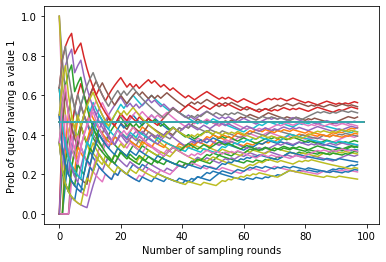

In [14]:
for i in range(0, len(markov_chains_list)):
  plot_95_pct_confidence_interval(markov_chains_list[i], 'S3', 1)

{'Pr[0]': 0.54, 'Pr[1]': 0.46}


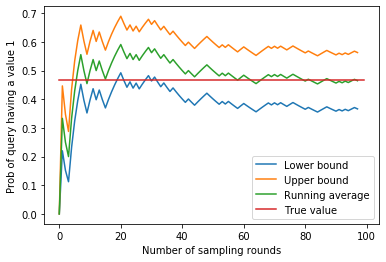

In [32]:
def plot_95_pct_confidence_interval(data_df, var, step): 
  """
  Input: dataframe, variable on dataframe to plot, burning step 
  """
  lower_bounds = []
  upper_bounds = []
  means= []
  # data_df = data_df[step:]
  #query3 = [0.333] * len(data_df)
  query2 = [0.4667]* len(data_df)
  for i in range(1, len(data_df[var])):
    sample_mean = data_df[var][0:i].mean()
    std_error = math.sqrt(data_df[var][0:i].var()/len(data_df))
    Z = 1.96 # based on 95% confidence interval
    epsilon = Z * std_error
    lower_bounds.append(sample_mean - epsilon)
    upper_bounds.append(sample_mean + epsilon)
    means.append(sample_mean)
  
  
  print({ 'Pr[0]': 1- data_df[var].mean(), 'Pr[1]':data_df[var].mean()})
  plt.plot(lower_bounds[step:], label = 'Lower bound')
  plt.plot(upper_bounds[step:], label= 'Upper bound')
  plt.plot(means[step:], label = 'Running average')
  plt.plot(query2, label = 'True value')
  plt.legend()
  plt.xlabel("Number of sampling rounds")
  plt.ylabel("Prob of query having a value 1")
  return means, lower_bounds, upper_bounds


means, lower_bounds, upper_bounds = plot_95_pct_confidence_interval(markov_chains_list[3], 'S3', 1 ) 

True values for this query: 
```
+-------+-----------+
| S3    |   phi(S3) |
+=======+===========+
| S3(0) |    0.5333 |
+-------+-----------+
| S3(1) |    0.4667 |
+-------+-----------+
```

In [18]:
break

SyntaxError: ignored

### **Using My Variable Elimination**

In [0]:
model_var_elim = MyBayesianModel([('S1', 'O1'), ('S1', 'S2'), ('S2', 'O2'), ('S2', 'S3'), ('S3', 'O3')])
cpd_s1 = TabularCPD(variable='S1', variable_card=2, values=[[1,0]])
cpd_s2 = TabularCPD(variable='S2', variable_card=2,
                   values=[[0.8, 0],
                           [0.2, 1]],
                   evidence=['S1'],
                   evidence_card=[2])
cpd_s3 = TabularCPD(variable='S3', variable_card=2,
                   values=[[0.8, 0],
                           [0.2, 1]],
                   evidence=['S2'],
                   evidence_card=[2])

cpd_o1 = TabularCPD(variable='O1', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S1'],
                   evidence_card=[2])

cpd_o2 = TabularCPD(variable='O2', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S2'],
                   evidence_card=[2])


cpd_o3 = TabularCPD(variable='O3', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S3'],
                   evidence_card=[2])

model_var_elim.add_cpds([cpd_s1, cpd_s2, cpd_s3, cpd_o1, cpd_o2, cpd_o3])

infer = MyVariableElimination(model_var_elim)
df = infer.query(['S3'], {'O1':1, 'O2':0, 'O3':1})
df

### **Using PGMPY**

In [0]:
! pip install pgmpy
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianModel([('S1', 'O1'), ('S1', 'S2'), ('S2', 'O2'), ('S2', 'S3'), ('S3', 'O3')])

cpd_s1 = TabularCPD(variable='S1', variable_card=2, values=[[1,0]])
cpd_s2 = TabularCPD(variable='S2', variable_card=2,
                   values=[[0.8, 0],
                           [0.2, 1]],
                   evidence=['S1'],
                   evidence_card=[2])
cpd_s3 = TabularCPD(variable='S3', variable_card=2,
                   values=[[0.8, 0],
                           [0.2, 1]],
                   evidence=['S2'],
                   evidence_card=[2])

cpd_o1 = TabularCPD(variable='O1', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S1'],
                   evidence_card=[2])

cpd_o2 = TabularCPD(variable='O2', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S2'],
                   evidence_card=[2])


cpd_o3 = TabularCPD(variable='O3', variable_card=2,
                   values=[[0.5, 0],
                           [0.5, 1]],
                   evidence=['S3'],
                   evidence_card=[2])

model.add_cpds(cpd_s1, cpd_s2, cpd_s3, cpd_o1, cpd_o2, cpd_o3)
infer2 = VariableElimination(model)


print(infer2.query(['S3'], evidence={'O1':1, 'O2':0, 'O3':1}))

